Fetching historical data for $HDFCBANK.NS


[*********************100%***********************]  1 of 1 completed


Data fetched successfully.

Performing ARIMA Prediction...
Fetching tweets for HDFCBANK.NS...
Global Polarity: -0.9706999999999978
Positive Tweets: 43, Negative Tweets: 37

Predicted business days and adjusted prices for HDFCBANK.NS:
  Predicted Date  Predicted Price
0     2024-12-24      1796.582530
1     2024-12-25      1796.475437
2     2024-12-26      1795.163819
3     2024-12-27      1796.016013
4     2024-12-30      1798.049767
5     2024-12-31      1795.882724
6     2025-01-01      1796.847790


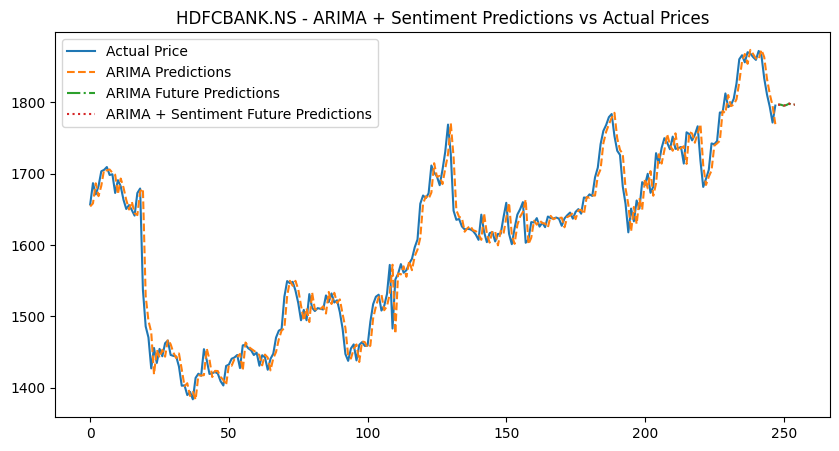

HDFCBANK.NS - ARIMA + Sentiment RMSE: 22.95982101114293


In [1]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import requests

# **************** FETCH HISTORICAL STOCK DATA ********************
DataFetch = input("Enter the stock name : ")
def get_historical(quote):
    """
    Fetch historical stock price data using Yahoo Finance.
    """
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    if df.empty:
        print(f"Error fetching data for {quote}. Please check the symbol or source.")
    return df

# **************** FETCH TWEETS AND PERFORM SENTIMENT ANALYSIS ********************
def fetch_tweets(query, cursor=None):
    """
    Fetch tweets using the RapidAPI Twitter API.
    """
    url = "https://twitter-api45.p.rapidapi.com/search.php"
    headers = {
        "x-rapidapi-key": "4ec154cc17mshfb1a17a88a74772p159e36jsn6467a42c7d46",
        "x-rapidapi-host": "twitter-api45.p.rapidapi.com"
    }
    querystring = {"query": query, "search_type": "Latest"}
    if cursor:
        querystring["cursor"] = cursor

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        data = response.json()
        return data.get("timeline", []), data.get("next_cursor")
    else:
        print(f"Error: {response.status_code}")
        return [], None

def analyze_tweet_sentiment(tweets):
    """
    Analyze sentiment of tweets using VADER.
    """
    analyzer = SentimentIntensityAnalyzer()
    global_polarity = 0
    positive_count = negative_count = 0

    for tweet in tweets:
        text = tweet.get("text", "")
        sentiment_score = analyzer.polarity_scores(text)
        global_polarity += sentiment_score["compound"]

        if sentiment_score["compound"] >= 0.05:
            positive_count += 1
        elif sentiment_score["compound"] <= -0.05:
            negative_count += 1

    return global_polarity, positive_count, negative_count

def retrieve_tweets_polarity(symbol_name):
    """
    Retrieve tweets for a stock symbol and analyze sentiment.
    """
    print(f"Fetching tweets for {symbol_name}...")
    all_tweets = []
    cursor = None
    api_call_count = 0

    # Fetch tweets with a limit of 5 API calls
    while api_call_count < 5:
        tweets, cursor = fetch_tweets(symbol_name, cursor)
        if not tweets:
            break
        all_tweets.extend(tweets)
        api_call_count += 1
        if not cursor:
            break

    if not all_tweets:
        print("No tweets found for this symbol.")
        return 0  # Neutral sentiment

    # Analyze the sentiment of the fetched tweets
    global_polarity, positive_count, negative_count = analyze_tweet_sentiment(all_tweets)
    print(f"Global Polarity: {global_polarity}")
    print(f"Positive Tweets: {positive_count}, Negative Tweets: {negative_count}")
    return global_polarity / len(all_tweets)

# **************** ARIMA ALGORITHM WITH SENTIMENT INTEGRATION ********************
def ARIMA_with_sentiment(df, quote=None):
    """
    Perform ARIMA prediction and adjust with sentiment analysis.
    """
    def arima_model(train, test, n_forecast):
        history = [x for x in train]
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=(6, 1, 1))
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])

        # Forecast for the next n_forecast days
        for _ in range(n_forecast):
            model = ARIMA(history, order=(6, 1, 1))
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(yhat)

        return predictions

    if quote:
        df = df[df['Code'] == quote]

    unique_companies = df["Code"].unique()
    for company in unique_companies[:1]:  # Process only the given stock symbol
        data = df[df['Code'] == company].reset_index()
        data['Price'] = data['Close']
        price_values = np.nan_to_num(data['Price'].astype(float).values)
        train_size = int(len(price_values) * 0.80)
        train, test = price_values[:train_size], price_values[train_size:]

        # Fetch sentiment score
        sentiment = retrieve_tweets_polarity(DataFetch)
        n_forecast = 7  # Number of days to forecast
        predictions = arima_model(train, test, n_forecast)

        # Adjust predictions with sentiment score
        adjusted_predictions = [pred + sentiment for pred in predictions[-n_forecast:]]

        # Calculate predicted future business days
        last_date = data['Date'].iloc[-1]
        forecast_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq='B')[1:]

        # Prepare the table for the predicted dates and prices
        forecast_df = pd.DataFrame({
            'Predicted Date': forecast_dates.strftime('%Y-%m-%d'),
            'Predicted Price': adjusted_predictions
        })

        # Print the table
        print(f"\nPredicted business days and adjusted prices for {company}:")
        print(forecast_df)

        # Plot actual vs predicted prices
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(test)), test, label='Actual Price')
        plt.plot(range(len(test)), predictions[:len(test)], label='ARIMA Predictions', linestyle='--')
        plt.plot(range(len(test), len(test) + n_forecast), predictions[-n_forecast:], label='ARIMA Future Predictions', linestyle='-.')
        plt.plot(range(len(test), len(test) + n_forecast), adjusted_predictions, label='ARIMA + Sentiment Future Predictions', linestyle=':')
        plt.title(f'{company} - ARIMA + Sentiment Predictions vs Actual Prices')
        plt.legend()
        plt.show()

        # Calculate RMSE for test period
        error_arima = math.sqrt(mean_squared_error(test, predictions[:len(test)]))
        print(f"{company} - ARIMA + Sentiment RMSE: {error_arima}")

# **************** MAIN FUNCTION ********************
def main():
    """
    Main function to fetch stock data, perform ARIMA predictions, and adjust with sentiment analysis.
    """
    # Step 1: Fetch Historical Data
    print(f"Fetching historical data for ${DataFetch}")
    df = get_historical(DataFetch)
    if df.empty:
        print("No data available for this stock.")
        return
    print("Data fetched successfully.")

    # Step 2: Prepare Data for ARIMA
    print("\nPerforming ARIMA Prediction...")
    df_arima = df.reset_index()[['Date', 'Close']].copy()
    df_arima['Code'] = DataFetch

    # Step 3: Run ARIMA with Sentiment Adjustment
    ARIMA_with_sentiment(df_arima)

if __name__ == "__main__":
    main()
